In [111]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch
from fcmeans import FCM
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import mixed_precision
import os
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [112]:

gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, False)

# Enable XLA (fuses kernels)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
tf.config.optimizer.set_jit(True)

# 2) Enable mixed-precision for Tensor Cores on the T4
mixed_precision.set_global_policy('mixed_float16')
print("Compute dtype:", mixed_precision.global_policy().compute_dtype)
print("Variable dtype:", mixed_precision.global_policy().variable_dtype)

print("GPUs available:", tf.config.list_physical_devices('GPU'))
!nvidia-smi                              # shows GPU status and memory

Compute dtype: float16
Variable dtype: float32
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Thu May  8 21:52:18 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|         

In [113]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Configuration
# Configuration
DATA_PATH = '/content/drive/MyDrive/Cluster_4342/diabetes_data.csv'
FEATURES = [
    'Age','Sex','HighChol','CholCheck','BMI','Smoker',
    'HeartDiseaseorAttack','PhysActivity','Fruits','Veggies',
    'HvyAlcoholConsump','GenHlth','MentHlth','PhysHlth',
    'DiffWalk','Stroke','HighBP'
]
OUTCOME_COL = 'Diabetes'
N_CLUSTERS = 2  # binary clustering
N_ROWS = 500 # Due to RAM issues have to limit rows used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
# Load and preprocess
data = pd.read_csv(DATA_PATH, usecols=FEATURES + [OUTCOME_COL]).astype('float32')

#Randomize dataset and select only first 'N_ROWS' rows
data = data.sample(frac=1, random_state=42).reset_index(drop=True).iloc[:N_ROWS]

In [115]:
#Feature matrix and labels
X_df = data[FEATURES].fillna(data[FEATURES].median())
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)
y_true = data[OUTCOME_COL].values

In [116]:
# Determine optimal number of PCs via silhouette on KMeans
pc_scores = []
for n in range(2, min(X_scaled.shape[1], 11)):
    X_tmp = PCA(n_components=n, svd_solver='randomized', random_state=42).fit_transform(X_scaled)
    labels_tmp = KMeans(n_clusters=N_CLUSTERS, random_state=42).fit_predict(X_tmp)
    sil_tmp = silhouette_score(X_tmp, labels_tmp)
    pc_scores.append((n, sil_tmp))
best_pc_n, best_pc_sil = max(pc_scores, key=lambda x: x[1])
print(f"Optimal PCA components: {best_pc_n} (Silhouette={best_pc_sil:.3f})")

Optimal PCA components: 2 (Silhouette=0.483)


In [117]:
# Apply PCA with chosen number of components
pca = PCA(n_components=best_pc_n, svd_solver='randomized', random_state=42)
X_reduced = pca.fit_transform(X_scaled)

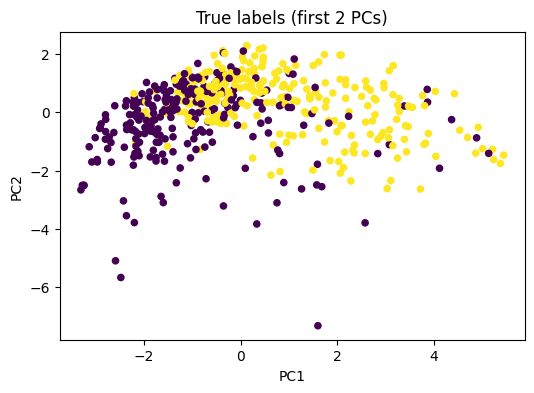

In [118]:
# Visualization: first two principal components
X_vis = X_reduced[:, :2]
plt.figure(figsize=(6,4))
plt.scatter(X_vis[:,0], X_vis[:,1], c=y_true, s=20)
plt.title('True labels (first 2 PCs)')
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()

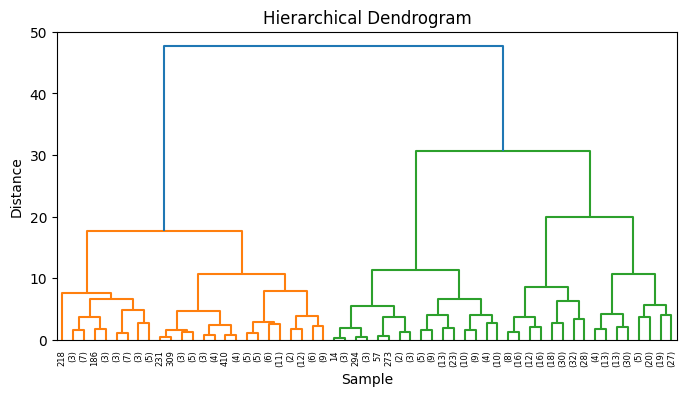

In [119]:
# Hierarchical clustering dendrogram
Z = linkage(X_reduced, method='ward')
plt.figure(figsize=(8,4))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Dendrogram')
plt.xlabel('Sample'); plt.ylabel('Distance'); plt.show()

In [120]:
# After A lot of testing these were the best parameters I could get with the time I had.
best_km_params = {'init': 'k-means++', 'algorithm': 'lloyd', 'n_init': 10, 'max_iter': 300}
best_hc_linkage = 'single'
best_db_params = {'eps': 0.935, 'min_samples': 2}
best_fcm_m = 1.01
best_gmm_params = {'covariance_type': 'spherical', 'reg_covar': 0.1}

# Define final clustering models with best‑found parameters
models = [
    ('KMeans', KMeans(
        n_clusters=N_CLUSTERS,
        init=best_km_params['init'],
        algorithm=best_km_params['algorithm'],
        n_init=best_km_params['n_init'],
        max_iter=best_km_params['max_iter'],
        random_state=42
    )),
    ('Hierarchical', AgglomerativeClustering(
        n_clusters=N_CLUSTERS,
        linkage=best_hc_linkage
    )),
    ('DBSCAN', DBSCAN(
        eps=best_db_params['eps'],
        min_samples=best_db_params['min_samples']
    )),
    ('FuzzyCMeans', FCM(
        n_clusters=N_CLUSTERS,
        m=best_fcm_m
    )),
    ('GMM', GaussianMixture(
        n_components=N_CLUSTERS,
        covariance_type=best_gmm_params['covariance_type'],
        random_state=42,
        reg_covar=best_gmm_params['reg_covar']
    )),
    ('BIRCH', Birch(
        n_clusters=N_CLUSTERS
    ))
]

labels_store = {}

results = []

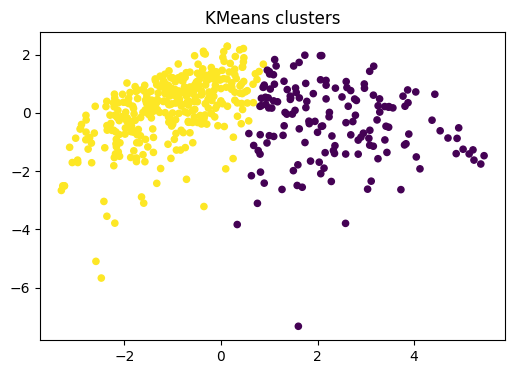

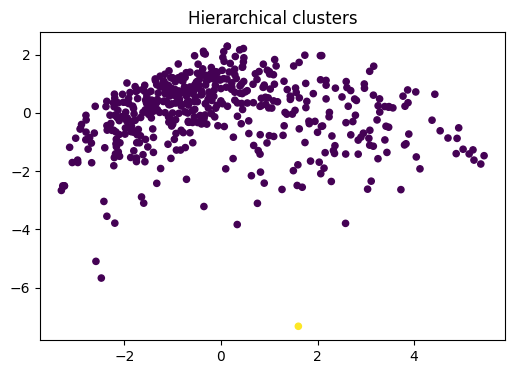

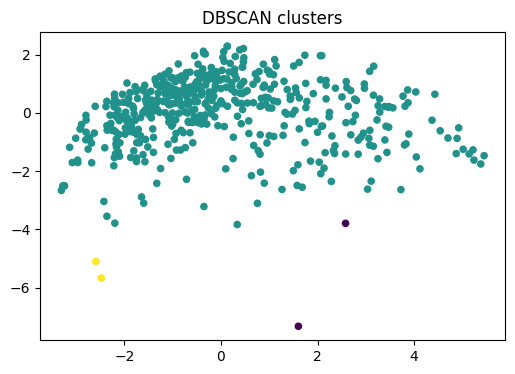

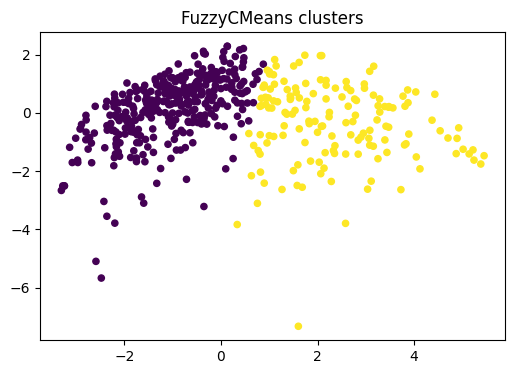

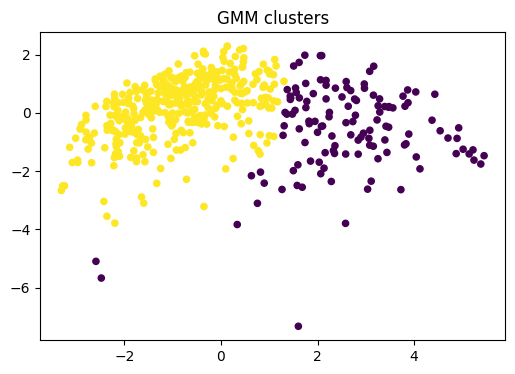

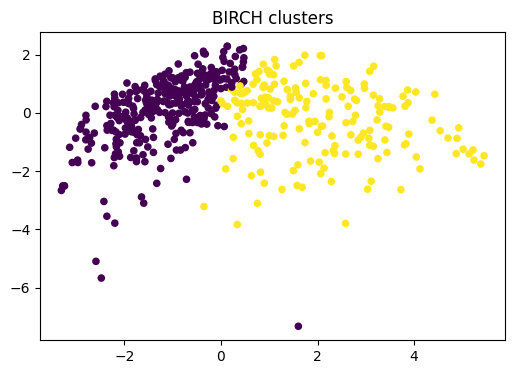

In [121]:
for name, model in models:
    # fit and predict, handle exceptions for FCM
    if name == 'FuzzyCMeans':
        try:
            model.fit(X_reduced)
            labels = model.u.argmax(axis=1)
        except Exception:
            labels = np.zeros(len(X_reduced), dtype=int)
    elif name == 'GMM':
        labels = model.fit_predict(X_reduced)
    else:
        labels = model.fit_predict(X_reduced)
    labels_store[name] = labels

    # visualization
    plt.figure(figsize=(6,4))
    plt.scatter(X_vis[:,0], X_vis[:,1], c=labels, s=20)
    plt.title(f'{name} clusters'); plt.show()

    # compute metrics, guard against single-label cases
    unique_labels = np.unique(labels)
    if len(unique_labels) > 1:
        sil = silhouette_score(X_reduced, labels)
        dbi = davies_bouldin_score(X_reduced, labels)
    else:
        sil = np.nan
        dbi = np.nan
    ari = adjusted_rand_score(y_true, labels)
    nmi = normalized_mutual_info_score(y_true, labels)

    results.append({
        'Algorithm': name,
        'Silhouette': sil,
        'Davies-Bouldin': dbi,
        'ARI': ari,
        'NMI': nmi
    })

# Evaluation Score
* Silhouette: -1 to 1, Closer to 1 the better
* Davies-Bouldin: 0 to infinity, closer to 0 the better
* ARI: -1 to 1, Closer to 1 the better
* NMI 0 to 1, Closer to 1 the better

In [122]:
# Display evaluation table
metrics_df = pd.DataFrame(results)
display(metrics_df)

,Algorithm,Silhouette,Davies-Bouldin,ARI,NMI
0,KMeans,0.482994,0.837581,0.093182,0.096772
1,Hierarchical,0.635839,0.257976,0.000264,0.004111
2,DBSCAN,0.499860,0.570675,0.001186,0.015682
3,FuzzyCMeans,0.482994,0.837581,0.093182,0.096772
4,GMM,0.501530,0.823484,0.070190,0.090832
5,BIRCH,0.448052,0.894241,0.111185,0.099596


KMeans Confusion Matrix (counts):
[[ 34 208]
 [119 139]]



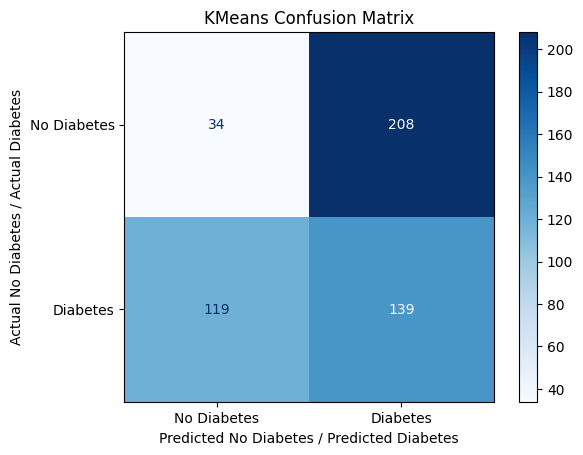

Hierarchical Confusion Matrix (counts):
[[241   1]
 [258   0]]



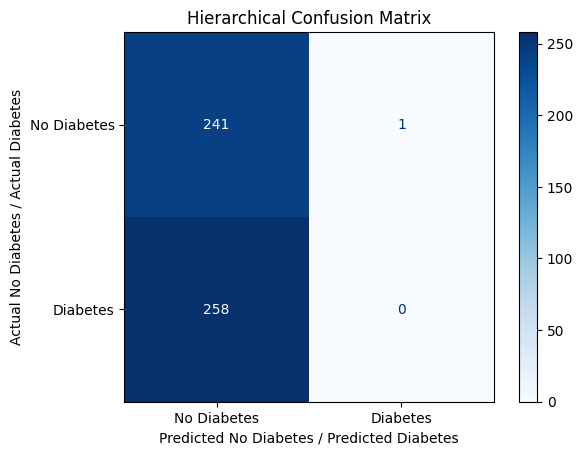

FuzzyCMeans Confusion Matrix (counts):
[[208  34]
 [139 119]]



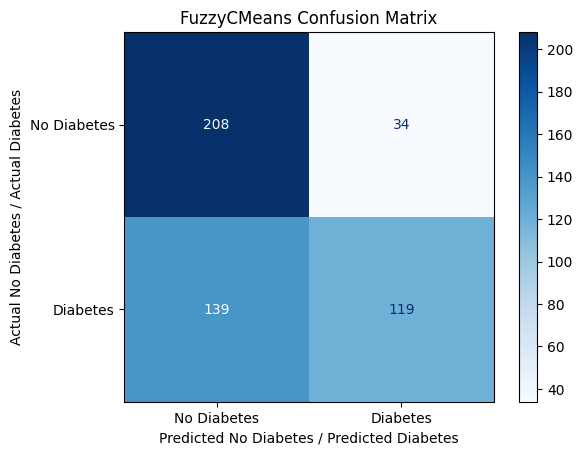

GMM Confusion Matrix (counts):
[[ 25 217]
 [100 158]]



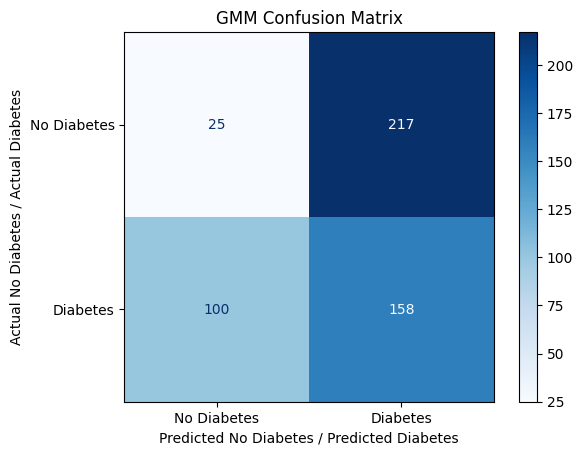

BIRCH Confusion Matrix (counts):
[[198  44]
 [122 136]]



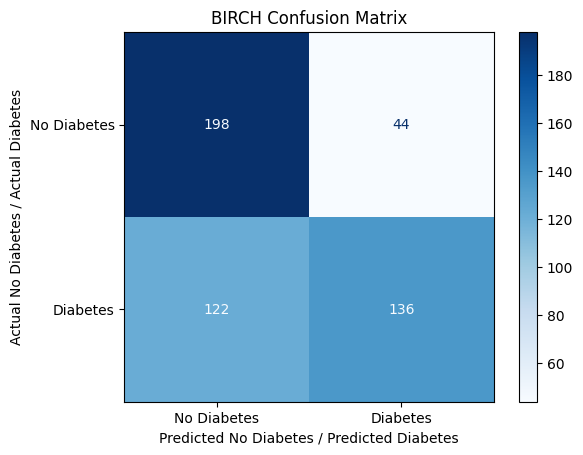

In [123]:
# Confusion matrices for valid models
for name, labels in labels_store.items():
    if len(np.unique(labels)) == N_CLUSTERS:
        cm = confusion_matrix(y_true, labels)
        print(f"{name} Confusion Matrix (counts):\n{cm}\n")
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Diabetes','Diabetes'])
        disp.plot(cmap='Blues')
        plt.xlabel('Predicted No Diabetes / Predicted Diabetes')
        plt.ylabel('Actual No Diabetes / Actual Diabetes')
        plt.title(f'{name} Confusion Matrix')
        plt.show()

In [124]:
# Cluster centroids and sizes in PC space
features_df = pd.DataFrame(X_reduced, columns=[f'PC{i+1}' for i in range(best_pc_n)])
for name, labels in labels_store.items():
    if name == 'DBSCAN': continue
    features_df['cluster'] = labels
    summary = features_df.groupby('cluster').mean()
    summary['size'] = features_df.groupby('cluster').size()
    print(f"{name} centroids and sizes (in PC space):")
    display(summary.round(2))

KMeans centroids and sizes (in PC space):


,PC1,PC2,size
cluster,,,
0,2.35,-0.36,153
1,-1.04,0.16,347


Hierarchical centroids and sizes (in PC space):


,PC1,PC2,size
cluster,,,
0,-0.0,0.01,499
1,1.6,-7.32,1


FuzzyCMeans centroids and sizes (in PC space):


,PC1,PC2,size
cluster,,,
0,-1.04,0.16,347
1,2.35,-0.36,153


GMM centroids and sizes (in PC space):


,PC1,PC2,size
cluster,,,
0,2.61,-0.6,125
1,-0.87,0.2,375


BIRCH centroids and sizes (in PC space):


,PC1,PC2,size
cluster,,,
0,-1.15,0.13,320
1,2.05,-0.23,180


In [125]:
# Recommendations based on results
best_int = metrics_df.loc[metrics_df['Silhouette'].idxmax(), 'Algorithm']
best_ext = metrics_df.loc[metrics_df['ARI'].idxmax(), 'Algorithm']
print(f"Best internal algorithm: {best_int}")
print(f"Best external algorithm: {best_ext}")

Best internal algorithm: Hierarchical
Best external algorithm: BIRCH
